In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("new_dataset.csv")

In [3]:
# Split into features and labels
X = df['text'].values
y = df['sentiment'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 0=Negative, 1=Positive

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
trunc_type = 'post'
padding_type = 'post'

X_train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

X_test_padded = pad_sequences(
    test_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

In [5]:
model = Sequential([
    Embedding(5000, 64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(24, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_padded,
    y_train,
    epochs=15,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stop],
    batch_size=64
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5296 - loss: 0.6836 - val_accuracy: 0.7175 - val_loss: 0.5532
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7628 - loss: 0.5113 - val_accuracy: 0.7285 - val_loss: 0.5332
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8499 - loss: 0.3794 - val_accuracy: 0.7305 - val_loss: 0.5395
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8892 - loss: 0.3008 - val_accuracy: 0.7325 - val_loss: 0.6223
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9223 - loss: 0.2257 - val_accuracy: 0.7105 - val_loss: 0.6956


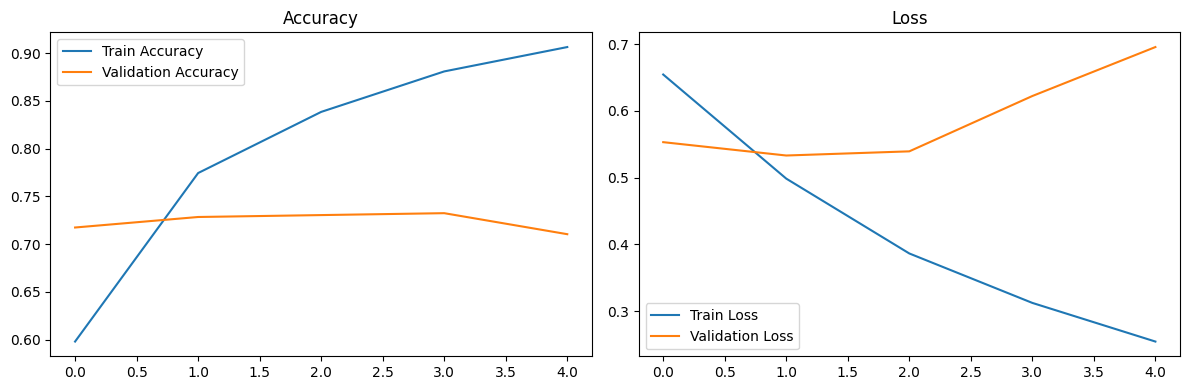

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7289 - loss: 0.5269

Test Accuracy: 0.7285


In [7]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'\nTest Accuracy: {accuracy:.4f}')

In [8]:
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    prediction = model.predict(padded)
    sentiment = 'Positive' if prediction > 0.5 else 'Negative'
    confidence = prediction[0][0] if sentiment == 'Positive' else 1 - prediction[0][0]
    return f"{sentiment} (Confidence: {confidence:.2f})"

# Test with sample text
sample_text = "I feel absolutely delighted about this wonderful surprise!"
print(predict_emotion(sample_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Positive (Confidence: 0.55)
